In [2]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from tdc.single_pred import Tox

In [5]:
from tdc.utils import retrieve_label_name_list

retrieve_label_name_list('herg_central')

['hERG_at_1uM', 'hERG_at_10uM', 'hERG_inhib']

In [3]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        positions = tf.range(0, 200, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    
    
    
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs,attention_mask=tf.cast(np.array([[1]*200] + [[0]+[1]*199]*199),bool))
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim,vocab_num=1300):
        super(BERT, self).__init__()
        self.transform_block = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,vocab_num,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(vocab_num,activation = 'softmax')
        
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        hidden = self.embedding(inputs)
        for i in range(8):
            hidden = self.transform_block(hidden)
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = tf.keras.layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [4]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
#pos = get_sinusoid_encoding_table(200,300)

inputs = Input(shape=(200,))
x = embedding_layer_fix(inputs)
outputs = Sequential([
    layers.LSTM(256, return_sequences=True, input_shape=(200, 256)),
    layers.Dropout(0.4),
    layers.Bidirectional(layers.LSTM(256)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])(x)
LSTM_model = Model(inputs= [inputs], outputs=[outputs])
LSTM_model.summary()

NameError: name 'embedding_layer_fix' is not defined

In [ ]:
BERT_model = BERT_train('./data/L_model_weights.h5')

2023-11-28 14:53:35.334607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 14:53:36.223523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78309 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 bert_1 (BERT)               (None, 200, 256)          3014144   
                                                                 
 tf.__operators__.getitem (S  (None, 256)              0         
 licingOpLambda)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,080,193
Trainable params: 3,080,193
Non-trainable params: 0
_________________________________________________

In [ ]:
from Module import classification

models = {'BERT_model':BERT_model}

temp = classification.ModelPlotter(models,train,tox_info,[callback])
temp.model_fitting()

NameError: name 'train' is not defined

In [ ]:
x,y = temp.data_process('bit',True)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Embedding
pos = get_sinusoid_encoding_table(200,256)
def att_model(reps):
    pos = get_sinusoid_encoding_table(200,256)
    inputs = Input(shape=(200,))
    x = embedding_layer_fix(inputs)
    #inputs = LayerNormalization()(inputs)
    #pos = tf.range(start=0, limit=55, delta=1)
    #pos = Embedding(55, 256)(pos)
    x = x+pos/5

    for i in range(reps):
        x = TransformerBlock(256,10,256,rate=0.4)(x)

    outputs = x[:,0]


    outputs = Dense(256)(outputs)
    outputs = Dropout(0.2)(outputs)
    outputs = Dense(1,activation = 'sigmoid')(outputs)
    Att_model = Model(inputs= [inputs], outputs=[outputs])
    return Att_model
Att_model = att_model(3)
Att_model.summary()

NameError: name 'embedding_layer_fix' is not defined

In [ ]:
mask = att_mask(16)

embedding_layer = tf.keras.layers.Embedding(1459, 256,mask_zero=True, embeddings_initializer=tf.keras.initializers.Constant(np.array(embedding_mat)),trainable = True)
inputs = layers.Input(shape=(200,))


x = embedding_layer(inputs)
pos = layers.Input(shape=(200,))
pos_emb = layers.Embedding(200,256)(pos)
x = x + pos_emb

transformer_block = TransformerBlock(256,8, 1024)
transformer_block = TransformerBlock(256,8, 1024)
transformer_block = TransformerBlock(256,8, 1024)
transformer_block = TransformerBlock(256,8, 1024)
transformer_block = TransformerBlock(256,8, 1024)
transformer_block = TransformerBlock(256,8, 1024)
transformer_block = TransformerBlock(256,8, 1024)
transformer_block = TransformerBlock(256,8, 1024)
x = transformer_block(x)
x = x[:,0]
x = layers.Dropout(0.1)(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_temp = Model(inputs=[inputs,pos], outputs=outputs)
model_temp.summary()

NameError: name 'embedding_mat' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
X_train,x_test,Y_train,y_test = train_test_split(np.array(encoded),np.array(tox_info)/1.,test_size=0.2,random_state=125)
x_train,x_val,y_train,y_val = train_test_split(np.array(X_train),np.array(Y_train)/1.,test_size=0.2,random_state=125)

NameError: name 'np' is not defined

In [ ]:
import tensorflow as tf
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(256,100000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

In [ ]:
import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(256,100000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

In [ ]:
with tf.device('/device:GPU:0'):
    temp_history = BERT_model.fit(x_train,y_train,epochs=300,validation_data=(x_val,y_val),batch_size=32,callbacks=[callback])

NameError: name 'x_train' is not defined

In [ ]:
model_temp.compile(optimizer=Adam(),loss = 'binary_crossentropy',metrics=['acc'])
with tf.device('/device:GPU:0'):
    temp_history = model_temp.fit([x_train,pos_in_train],y_train,epochs=300,validation_data=([x_val,pos_in_val],y_val),batch_size=32,callbacks=[callback,early_stopping_cb])

NameError: name 'model_temp' is not defined

In [ ]:
Att_model.compile(optimizer=Adam(),loss = 'binary_crossentropy',metrics=['acc'])
with tf.device('/device:GPU:0'):
    Att_history_model = Att_model.fit(x_train,y_train,epochs=400,validation_data=([x_val],y_val),batch_size=32,callbacks=[callback,early_stopping_cb])

In [ ]:
LSTM_model.compile(optimizer=Adam(),loss = 'binary_crossentropy',metrics=['acc'])

with tf.device('/device:GPU:0'):
    history = LSTM_model.fit(x_train,y_train,epochs=100,validation_data=(x_val,y_val),batch_size=32,callbacks=[early_stopping_cb])

In [ ]:
LSTM_model.evaluate(x_test,y_test)
Att_model.evaluate(x_val,y_val)

 4/84 [>.............................] - ETA: 1s - loss: 1.1224 - acc: 0.8047

67/67 [==============================] - 2s 19ms/step - loss: 1.2197 - acc: 0.7997


[1.2196515798568726, 0.7997185587882996]

In [ ]:
pos_in_test = np.array([[i for i in range(200)]]*len(x_test))

In [ ]:
model_temp.evaluate([x_test_1,pos_in_test],y_test)

In [ ]:
from Module import RDK as rk
train_NN,tox_info_NN= train,tox_info
train_NN = list(train_NN)
tox_info_NN = list(tox_info_NN)

for i in remove_list:
    train_NN.pop(i)


bit_string = rk.smile_to_RDkit(train_NN,2048)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
inputs = Input(shape=(2048,),name='input')
outputs = Dense(250,activation = 'relu')(inputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(40,activation = 'relu')(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(10,activation = 'relu')(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(1,activation = 'sigmoid')(outputs)

model_NN = Model(inputs= [inputs], outputs=[outputs])
model_NN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_18 (Dense)            (None, 250)               512250    
                                                                 
 dropout_9 (Dropout)         (None, 250)               0         
                                                                 
 dense_19 (Dense)            (None, 40)                10040     
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                                                 
 dense_20 (Dense)            (None, 10)                410       
                                                                 
 dropout_11 (Dropout)        (None, 10)                0   

In [ ]:
X_train_NN,x_test_NN,Y_train_NN,y_test_NN = train_test_split(np.array(bit_string)/1.,np.array(tox_info_NN)/1.,test_size=0.2,random_state=125)
x_train_NN,x_val_NN,y_train_NN,y_val_NN = train_test_split(np.array(X_train_NN)/1.,np.array(Y_train_NN)/1.,test_size=0.2,random_state=125)

In [ ]:
model_NN.compile(loss = 'binary_crossentropy',optimizer='Adam',metrics=['acc',auc])

In [ ]:
model_NN.fit(x_train_NN,y_train_NN,epochs=50,validation_data=(x_val_NN,y_val_NN),batch_size=20)

Epoch 1/50
21/21 [==============================] - 3s 25ms/step - loss: 0.5288 - acc: 0.7687 - auc: 0.4695 - val_loss: 0.3909 - val_acc: 0.8812 - val_auc: 0.4663
Epoch 2/50
21/21 [==============================] - 0s 13ms/step - loss: 0.4029 - acc: 0.8806 - auc: 0.4714 - val_loss: 0.3863 - val_acc: 0.8812 - val_auc: 0.5478
Epoch 3/50
21/21 [==============================] - 0s 13ms/step - loss: 0.2822 - acc: 0.8881 - auc: 0.7387 - val_loss: 0.3867 - val_acc: 0.8812 - val_auc: 0.6086
Epoch 4/50
21/21 [==============================] - 0s 13ms/step - loss: 0.2547 - acc: 0.8881 - auc: 0.8004 - val_loss: 0.4089 - val_acc: 0.8812 - val_auc: 0.6278
Epoch 5/50
21/21 [==============================] - 0s 14ms/step - loss: 0.2001 - acc: 0.9204 - auc: 0.8908 - val_loss: 0.4340 - val_acc: 0.8812 - val_auc: 0.6615
Epoch 6/50
21/21 [==============================] - 0s 14ms/step - loss: 0.1376 - acc: 0.9328 - auc: 0.9708 - val_loss: 0.5147 - val_acc: 0.8713 - val_auc: 0.6404
Epoch 7/50
21/21 [====

In [ ]:
model_NN.evaluate(x_test_NN,y_test_NN)

85/85 [==============================] - 1s 6ms/step - loss: 0.6991 - acc: 0.8144


[0.6990967988967896, 0.8144291639328003]

In [ ]:
def plot_model_acc(history,model_name=''):
    ## Accuracy plot
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(model_name+'Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_model_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
   

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = BERT_model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

2/2 [==============================] - 1s 32ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

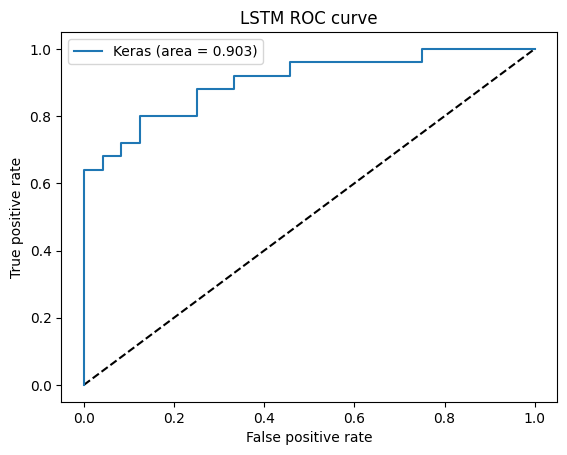

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LSTM ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model_NN.predict(x_val_NN).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_NN, y_pred_keras)

3/3 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

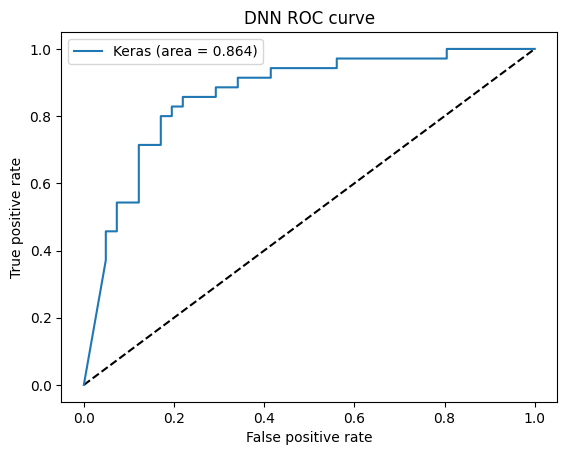

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DNN ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(np.array(temp_image),np.array(temp_tox_image)/1.,test_size=0.2,random_state=125)